# CLT Project - Stage III





- **Author:**             Arian Contessotto, Tim Giger, Levin Reichmuth
- **Submission Date:**    1 June 2023

## 1. Setup & Data Loading

If running on Colab, install the required packages and load data.

In [ ]:
# Clone repo with dataset
!git clone https://github.com/syX113/hslu-nlp

In [ ]:
# Check if files are loaded
!ls hslu-nlp/stage2/annotated/

In [ ]:
# Required package installation
!transformers==4.28.0
!pip install torch

### 1.1 Import Packages & Downloads

In [1]:
# Imports
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from peft import get_peft_model, LoraConfig, TaskType
from peft import PeftModel, PeftConfig
from transformers import EarlyStoppingCallback
from IPython.display import Image, display
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

2023-05-30 19:12:13.412567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-30 19:12:13.579396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 19:12:14.335193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


The final dataframe from stage one is loaded. These data are the basis for stage two.

In [52]:
# Define function to load and merge data
def load_old_sentiments(file='../stage2/annotated/full_llm_annotated.csv'):
    df = pd.read_csv(file, delimiter = '|')
    # Apply eval function
    df['esg_topics'] = df['esg_topics'].apply(eval)
    df['sentence_tokens'] = df['sentence_tokens'].apply(eval)
    df['st2_sentiment_llm_continuous'] = df['sentiment_llm_continuous'].apply(eval)
    df['st2_sentiment_llm_categorical'] = df['sentiment_llm_categorial'].apply(eval)

    return df

def load_new_sentiments(file='../stage2/output/stage2_output.csv'):
    df = pd.read_csv(file, delimiter = '|')
    # Apply eval function
    df['esg_topics'] = df['esg_topics'].apply(eval)
    df['sentence_tokens'] = df['sentence_tokens'].apply(eval)
    df['st2_sentiment_llm_continuous'] = df['st2_sentiment_llm_continuous'].apply(eval)
    df['st2_sentiment_llm_categorical'] = df['st2_sentiment_llm_categorical'].apply(eval)

    return df

df = load_old_sentiments()

# Print shape and diyplay header
print(df.shape)
df.head()

(11071, 19)


,company,datatype,title,date,domain,esg_topics,internal,symbol,sentence_tokens,market_cap_in_usd_b,sector,industry,year_month,year,month,sentiment_llm_continuous,sentiment_llm_categorial,st2_sentiment_llm_continuous,st2_sentiment_llm_categorical
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,NaN,"[CleanWater, GHGEmission, ProductLiability, Va...",1,BEI,[brands strategy sustainability agenda care be...,25.99,Consumer Staples,Household & Personal Products,2021-03,2021,3,"[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...","[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ..."
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,DTE,"[management facts, deutsche telekom cr report,...",101.78,Communication Services,Telecom Services,2021-03,2021,3,"[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ...","[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ..."
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,NaN,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,VNA,"[sustainable future, sustainability report dea...",20.35,Real Estate,Real Estate Services,2021-03,2021,3,"[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ...","[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ..."
3,Merck,sustainability_report,MerckKGaA Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, DataMisuse, DrugResistance, Iso...",1,MRK,[management employees profile attractive emplo...,87.64,Healthcare,Drug Manufacturers—Specialty & Generic,2021-03,2021,3,"[0.36378589272499084, 0.6118267178535461, 0.48...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.36378589272499084, 0.6118267178535461, 0.48...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ..."
4,MTU,sustainability_report,MTUAeroEngines Sustainability Report 2020,2020-03-31,NaN,"[WorkLifeBalance, Corruption, AirQuality, Data...",1,MTX,[sustainability goes far beyond climate action...,12.24,Industrials,Aerospace & Defense,2020-03,2020,3,"[0.46082836389541626, 0.46208637952804565, 0.4...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ...","[0.46082836389541626, 0.46208637952804565, 0.4...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ..."


In [6]:
# Flatten the continuous sentiments to analyze distribution and adjust class discretization to 0.0, 0.5 and 1.0
flattened_sentiments_cont = np.hstack(df['st2_sentiment_llm_continuous'].values)
flattened_sentiments_cat= np.hstack(df['st2_sentiment_llm_categorical'].values)

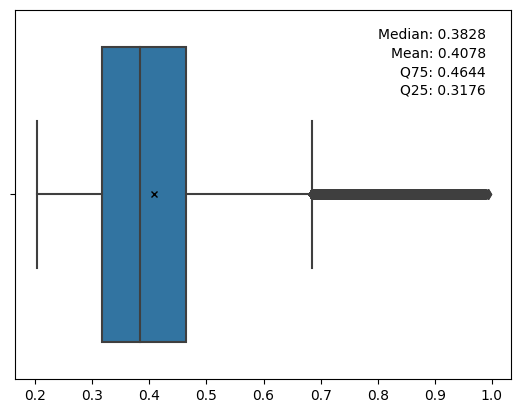

In [8]:
# Create boxplot
ax = sns.boxplot(x=flattened_sentiments_cont, showmeans=True,meanprops={"marker":"x","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"})

# Calculate statistics
median = np.median(flattened_sentiments_cont)
mean = np.mean(flattened_sentiments_cont)
q75, q25 = np.percentile(flattened_sentiments_cont, [75 ,25])
iqr = q75 - q25

# Add text with statistics
plt.text(0.95, 0.95, f"Median: {median:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.90, f"Mean: {mean:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.85, f"Q75: {q75:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.text(0.95, 0.80, f"Q25: {q25:.4f}", horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
plt.show()

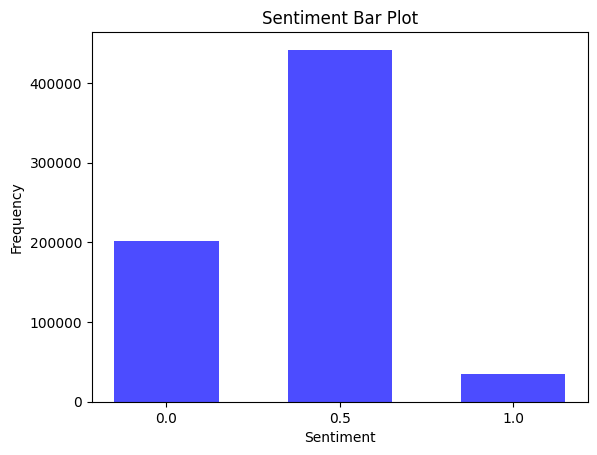

In [9]:
# Count the occurrences of each value
value_counts = pd.Series(flattened_sentiments_cat).value_counts()
# Create a bar plot with smaller bars
plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
plt.title('Sentiment Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0.0, 0.5, 1.0])
plt.show()

In [29]:
# Function to adjust the sentiment discretization
def discretize_sentiment(value):
    if value <= 0.3828: # Mean of st2_sentiment_llm_continuous
        return 0.0
    elif value <= 0.4644: # Q75 of st2_sentiment_llm_continuous + a small shift
        return 0.5
    else:
        return 1.0
    
def discretize_sentiments(sentiments):
    if sentiments is np.nan:
        return np.nan
    return [discretize_sentiment(sentiment) for sentiment in sentiments]

In [30]:
df['st2_sentiment_llm_categorical'] = df['st2_sentiment_llm_continuous'].apply(discretize_sentiments)

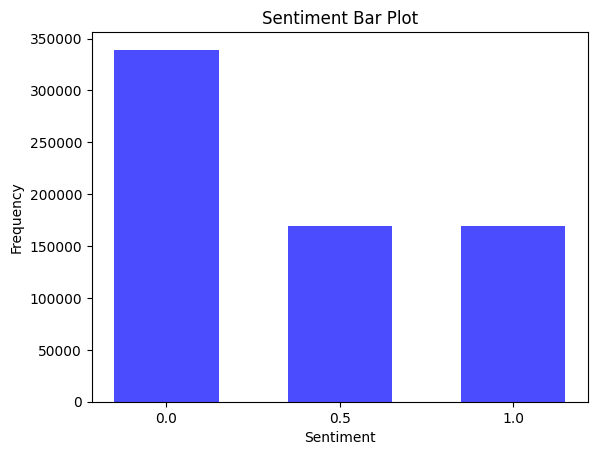

In [31]:
flattened_sentiments_cat= np.hstack(df['st2_sentiment_llm_categorical'].values)

# Count the occurrences of each value
value_counts = pd.Series(flattened_sentiments_cat).value_counts()
# Create a bar plot with smaller bars
plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
plt.title('Sentiment Bar Plot')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.xticks([0.0, 0.5, 1.0])
plt.show()

### 1.3 Create sampled and full Dataframes

In [14]:
def create_sentence_df(data):

    # Select relevant columns
    data = data[['internal','sentence_tokens','st2_sentiment_llm_categorical']]

    # Explode the tokens, so each sentence is a row
    data = data.set_index(['internal']).apply(pd.Series.explode).reset_index()

    # Rename the columns and change order
    data.rename(columns={'sentence_tokens': 'sentence', 'st2_sentiment_llm_categorical': 'sentiment'}, inplace=True)
    data = data[['internal', 'sentence', 'sentiment']]

    # Convert types
    data['internal'] = data['internal'].astype(int)
    data['sentence'] = data['sentence'].astype(str)
    data['sentiment'] = data['sentiment'].astype(float)
    
    return data

# Create sentence data
sentence_df = create_sentence_df(df)

# Display header and shape
print(sentence_df.shape)
sentence_df.head()

(678529, 3)


,internal,sentence,sentiment
0,1,brands strategy sustainability agenda care bey...,1.0
1,1,successfully reduced carbon footprint absolute...,1.0
2,1,end consumer business returned levels reduced ...,0.0
3,1,decoupling human economic activity natural res...,0.0
4,1,inspired beiersdorf ambitious sustainability a...,1.0


The subsets for the training should have equally distributed classes. In addition, external and internal documents should be represented.  
One of these conditions needs to be more "loose", we decide class equality is more important.

In [ ]:
def balance_sentiment_and_internal_sentences(df):
    # Get minimum number of observations across sentiment classes
    min_internal_count = df['sentiment'].value_counts().min()
    
    # Get the minimum number of observations between internal == 0 and internal == 1
    min_sentiment_count = min(df[df['internal'] == 0].shape[0], df[df['internal'] == 1].shape[0], min_internal_count)

    # Create "balanced" dataframe
    balanced_df = pd.concat([df[df['internal'] == i].sample(min_sentiment_count*3, random_state=1) for i in df['internal'].unique()]) # Factor needs to be choosen based on distriution (e.g. *3)

    return balanced_df

# Sample the sentence dataframe
sub_sentence_df = balance_sentiment_and_internal_sentences(sentence_df)

# Display header and shape
print(sub_sentence_df.shape)
sub_sentence_df.head()

In [11]:
# Inspect sampling results
print('Sentence subset class distributions:')
print(sub_sentence_df['internal'].value_counts())
print(sub_sentence_df['sentiment'].value_counts())

Sentence subset class distributions:
1    48225
0    48225
Name: internal, dtype: int64
0.0    46601
0.5    46543
1.0     3306
Name: sentiment, dtype: int64


In [12]:
# Drop uncessary column and reset index
sentence_df = sentence_df.drop(columns=['internal']).reset_index(drop=True)
sub_sentence_df = sub_sentence_df.drop(columns=['internal']).reset_index(drop=True)

As a result, the models can be trained on a subset dataset with adjusted class balance.  
After training and tuning, the best model is trained on the full sentence dataset. 

We considered a finetuning also with full documents. Due to the truncation, only the first 512 word tokens are used in the model.  
This leads to wrong/missleading training data and therefore we train the models only on the sentence level.

## 2. Model Finetuning

The evaluation for the model is based on the following conceptual approach:
1. Select multiple pretrained (Huggingface) models, based on previous stages
2. Train the selected models on a small subset of the single sentences to keep the training time short
3. Compare the training outcomes of the different models on the subset and select the best model


An overview of available LLMs is presented here: https://www.researchgate.net/figure/The-Pre-trained-language-model-family_fig4_342684048

In [23]:
# Function to compute the comparison metrics
def compute_metrics(p):
    pred, labels = p
    
    # Use the appropriate metrics, since we don't have discrete classes but a continous score 
    mse = mean_squared_error(y_true=labels, y_pred=pred)
    mae = mean_absolute_error(y_true=labels, y_pred=pred)
    r2 = r2_score(y_true=labels, y_pred=pred)

    return {"MSE": mse, "MAE": mae, "R2": r2}

In [16]:
# Load Tensorboard for training monitoring
%load_ext tensorboard

In [23]:
# Kill potential Tensorboard process, so it don't block the port
!pkill -f "tensorboard"

In [18]:
# Start Tensorboard to monitor training processes
%tensorboard --logdir ./evaluation/ --port 6010

### 1.1 Finetune Model 1: *distilbert-base-uncased*

As a first test, we use the lightweight "distilbert-base-uncased" model and fine-tune it on the full documents and the sentences, since the finetuned *"nlptown/bert-base-multilingual-uncased-sentiment"* demonstrated high alignment with the gold standard in stage 2.  
Since BERT only accepts 512 input word tokens, the full documents are heavyily truncated.  

🤗 page: https://huggingface.co/distilbert-base-uncased

In [26]:
# Define pretrained tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1) # 1 label to get a continuous score between 0 and 1

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.4.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'vocab_transform.bias', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.4.output_layer_norm.bias', 'distilbert.transformer.layer.1.attention.out_lin.bias', 'distilbert.transformer.l

In [27]:
# Create the torch datasets to use data in PyTorch and override necessary methods
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#### Finetune *distilbert-base-uncased* on sentence subset

In [29]:
# Split the data with a 70%, 15% and 15% ratio (train, valid, test)
X = list(sub_sentence_df["sentence"])
y = list(sub_sentence_df["sentiment"])
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3) # Split 70% train data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5) # Split the other 30% in 50% each to get the correct ratio

# Tokenize the datasets
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create the train, validation and test dataset as PyTorch datasets
train_dataset_distilbert_sent = Dataset(X_train_tokenized, y_train)
val_dataset_distilbert_sent = Dataset(X_val_tokenized, y_val)
test_dataset_distilbert_sent = Dataset(X_test_tokenized, y_test)

In [ ]:
# Define training arguments
args = TrainingArguments(
    output_dir="./evaluation/distilbert_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Define Huggingface Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset_distilbert_sent,
    eval_dataset=val_dataset_distilbert_sent,
    compute_metrics=compute_metrics
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/distilbert_sentences")

### 1.2 Finetune Model 2: *roberta-base*

As a second model for the comparison, we choose RoBERTa. It is a further development of BERT and should perform better.  

This model benefits substantially from extended training duration, larger data batches, and an increase in dataset size. Its performance further increases by eliminating the next sentence prediction objective and integrating longer sequences during training.  
Lastly, the model's optimization is boosted by dynamically altering the masking pattern applied to the training data.

Reference: https://arxiv.org/pdf/1907.11692.pdf  
🤗 page: https://huggingface.co/roberta-base

In [25]:
# Load default methods again, since a few are overwritten for destillbert
from datasets import Dataset

In [31]:
# Load the tokenizer for RoBERTa
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize_and_format_sentence(examples):

    # Tokenize the text and map sentiment to label
    tokenized_inputs = tokenizer(examples['sentence'], truncation=True, padding='max_length')
    labels = examples['sentiment']
    
    # Return both the tokenized inputs and labels
    return {**tokenized_inputs, 'labels': labels}

def tokenize_and_format_document(examples):
    # Same as above for documents
    tokenized_inputs = tokenizer(examples['document'], truncation=True, padding='max_length')
    labels = examples['sentiment']
    
    return {**tokenized_inputs, 'labels': labels}

In [32]:
# Load the base RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

#### Finetune *roberta-base* on sentence subset

In [33]:
# Train, validation and test split (70%, 15% and 15%)
train_dataset, temp_df = train_test_split(sub_sentence_df, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenizing the datasets
train_dataset_roberta_sent = train_dataset.map(tokenize_and_format_sentence, batched=True)
val_dataset_roberta_sent = val_dataset.map(tokenize_and_format_sentence, batched=True)
test_dataset_roberta_sent = test_dataset.map(tokenize_and_format_sentence, batched=True)

# Set the correct data format for PyTorch
train_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/67515 [00:00<?, ? examples/s]

Map:   0%|          | 0/14467 [00:00<?, ? examples/s]

Map:   0%|          | 0/14468 [00:00<?, ? examples/s]

In [ ]:
# Prepare to train the model
args = TrainingArguments(
    output_dir="./evaluation/roberta_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_roberta_sent,
    eval_dataset=val_dataset_roberta_sent
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./models/roberta_sentences")

### 1.3 Finetune Model 3: *xlnet-base-cased*

XLNet is a pretraining model for natural language processing tasks that combines the advantages of both autoregressive language models and denoising autoencoding models like BERT. 
Unlike BERT, XLNet mitigates dependency issues between masked positions and avoids a pretrain-finetune discrepancy by employing a generalized autoregressive method. 
This approach allows for learning bidirectional contexts by maximizing expected likelihood over all possible factorization orders. 
Furthermore, it integrates the strengths of Transformer-XL, a leading autoregressive model, into its pretraining procedure. 
Empirical evidence suggests that XLNet surpasses BERT in performance across a range of tasks including question answering, natural language inference, sentiment analysis, and document ranking.

Reference: https://arxiv.org/abs/1906.08237  
🤗 page: https://huggingface.co/xlnet-base-cased


In [34]:
# Load the tokenizer
tokenizer = XLNetTokenizerFast.from_pretrained('xlnet-base-cased')
# Load the XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=1)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [35]:
# Prepare the data
def prepare_data(sentences, labels):
    # Tokenize the inputs
    inputs = tokenizer(sentences, truncation=True, padding='max_length', max_length=512, return_tensors='pt')

    # Convert labels to tensors and resize to match input dimensions
    labels = torch.tensor(labels).unsqueeze(1).float()

    return inputs.input_ids, labels

# Create torch Dataset and adjust methods
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {'input_ids': self.encodings[idx], 'labels': self.labels[idx]}

    def __len__(self):
        return len(self.labels)

#### Finetune *xlnet-base-cased* on sentence subset

In [36]:
# Split the data with 70%, 15% and 15% 
train_df, temp_df = train_test_split(sub_sentence_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(sub_sentence_df, test_size=0.5, random_state=42)

# Get sentences and labels
train_sentences = train_df['sentence'].tolist()
train_labels = train_df['sentiment'].tolist()
val_sentences = val_df['sentence'].tolist()
val_labels = val_df['sentiment'].tolist()
test_sentences = test_df['sentence'].tolist()
test_labels = test_df['sentiment'].tolist()

# Prepare inputs and labels
train_input_ids, train_labels = prepare_data(train_sentences, train_labels)
val_input_ids, val_labels = prepare_data(val_sentences, val_labels)
test_input_ids, test_labels = prepare_data(test_sentences, test_labels)

# Create sentence datasets
train_dataset_xlnet_sent = SentimentDataset(train_input_ids, train_labels)
val_dataset_xlnet_sent = SentimentDataset(val_input_ids, val_labels)
test_dataset_xlnet_sent = SentimentDataset(test_input_ids, test_labels)

In [ ]:
# Define TrainingArguments
training_args = TrainingArguments(
    output_dir="./evaluation/xlnet_sentences",
    evaluation_strategy="steps",
    eval_steps=1000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_xlnet_sent,
    eval_dataset=val_dataset_xlnet_sent,
    compute_metrics=compute_metrics,
)

In [ ]:
# Delete GPU cache
torch.cuda.empty_cache()
# Train pre-trained model
trainer.train()
# Save the model
model.save_pretrained("./models/xlnet_sentences")

### 1.4 Finetune Model 4: *flan-t5-base* (not working correctly)

🤗 page: https://huggingface.co/google/flan-t5-base

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')

# Use correct Dataset class and adjust needed methods
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.float()
        self.decoder_input_ids = torch.ones((len(labels),1), dtype=torch.long) # Initialize with start token

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        item['decoder_input_ids'] = self.decoder_input_ids[idx]
        return item

    def __len__(self):
        return len(self.labels)


def prepare_data(sentences, labels):
    # Tokenize the inputs with added task-specific prefix ("sentiment")
    inputs = tokenizer(["sentiment: " + sentence for sentence in sentences], truncation=True, padding='max_length', max_length=512, return_tensors='pt')

    # Convert labels to tensors
    labels = torch.tensor(labels.to_numpy())

    dataset = SentimentDataset(inputs, labels)
    return dataset

sentence_data = sub_sentence_df['sentence']
label_data = sub_sentence_df['sentiment']

train_frac = 0.8
train_size = int(train_frac * len(sentence_data))

train_sentences = sentence_data[:train_size]
train_labels = label_data[:train_size]

val_sentences = sentence_data[train_size:]
val_labels = label_data[train_size:]

train_dataset = prepare_data(train_sentences, train_labels)
val_dataset = prepare_data(val_sentences, val_labels)

def compute_metrics_flan(eval_pred):
    predictions, labels = eval_pred

    # Reduce predictions to a single value per sequence (e.g., using mean)
    predictions = predictions.mean(dim=-1)

    mse = mean_squared_error(y_true=labels, y_pred=predictions)
    mae = mean_absolute_error(y_true=labels, y_pred=predictions)
    r2 = r2_score(y_true=labels, y_pred=predictions)

    return {"MSE": mse, "MAE": mae, "R2": r2}

class SentimentTrainer(Trainer):
    def predict(self, test_dataset):
        predictions, labels, _ = super().predict(test_dataset)
        # convert predicted token ids to float values
        predictions = [float(tokenizer.decode(pred)) for pred in predictions]
        return predictions, labels
    
    # Adjust loss function to regression
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Reduce logits to a single value per sequence (e.g., using mean)
        logits = logits.mean(dim=-1)

        # Use MSE loss for regression
        loss_fct = torch.nn.MSELoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./evaluation/flant5_sentences",
    evaluation_strategy="steps",
    eval_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

trainer = SentimentTrainer(
    model=model,              
    args=training_args, 
    compute_metrics=compute_metrics_flan,     
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Delete GPU cache
torch.cuda.empty_cache()

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./models/flant5_sentences")

T5 models are normally used for text-to-text tasks. Therefore, fine-tuning T5 for a classification task with a continous prediction between 0 and 1 is a bit of a diversion. Still, above code works and the training can be started.  
But the user-defined loss function does not work properly (it does not drop, but shows 0 throughout the training), and there is also uncertainty about the correct encodings.  

Therefore, this model is not considered.

## 3. Model Evaluation

The finetuned models are evaluated based on MSE, MAE and R2. In addition, the test datasets are used to test the predictions.  
For the evaluation the generated metrics out of the finetuning and inference on the test datasets are considered

In [57]:
# Load finetuned distilbert model
model_distilbert = BertForSequenceClassification.from_pretrained('./models/distilbert_sentences/', num_labels=1)

trainer_args_distilbert = TrainingArguments(
    output_dir="./inference/distilbert_sentences",
    fp16=True,
    report_to='tensorboard')

# Define distilbert test trainer
trainer_distilbert = Trainer(
    model=model_distilbert,
    compute_metrics=compute_metrics,
    args=trainer_args_distilbert)

# Make predictions on the test subset
pred_distilbert = trainer_distilbert.predict(test_dataset_distilbert_sent)

In [58]:
trainer_distilbert.evaluate(eval_dataset=test_dataset_distilbert_sent)

{'eval_loss': 0.1466914564371109,
 'eval_MSE': 0.1466914564371109,
 'eval_MAE': 0.31621062755584717,
 'eval_R2': -0.8697550970092274,
 'eval_runtime': 72.8464,
 'eval_samples_per_second': 198.61,
 'eval_steps_per_second': 24.833}

In [60]:
# Load finetuned RoBERTa model
model_roberta_sent = RobertaForSequenceClassification.from_pretrained('./models/roberta_sentences/', num_labels=1)

# Define RoBERTa test trainer
trainer_args_roberta = TrainingArguments(
    output_dir="./inference/roberta_sentences",
    fp16=True,
    report_to='tensorboard')

trainer_roberta = Trainer(
    model=model_roberta_sent,
    compute_metrics=compute_metrics,
    args=trainer_args_roberta)

# Make predictions on the test subset
pred_roberta_sent = trainer_roberta.predict(test_dataset_roberta_sent)

In [61]:
trainer_roberta.evaluate(eval_dataset=test_dataset_roberta_sent)

{'eval_loss': 0.1567980796098709,
 'eval_MSE': 0.1567980796098709,
 'eval_MAE': 0.31052500009536743,
 'eval_R2': -0.9772264512819131,
 'eval_runtime': 70.4653,
 'eval_samples_per_second': 205.321,
 'eval_steps_per_second': 25.672}

In [62]:
# Load finetuned XLNet model
model_xlnet = XLNetForSequenceClassification.from_pretrained('./models/xlnet_sentences/', num_labels=1)

# Define XLNet test trainer
trainer_args_xlnet = TrainingArguments(
    output_dir="./inference/xlnet_sentences",
    evaluation_strategy="steps",   
    eval_steps=100,
    logging_steps=10,
    gradient_accumulation_steps=4,
    fp16=True,
    report_to='tensorboard')

trainer_xlnet = Trainer(
    model=model_xlnet,
    compute_metrics=compute_metrics,
    args=trainer_args_xlnet)

# Make predictions on the test subset
pred_xlnet_sent = trainer_xlnet.predict(test_dataset_xlnet_sent)

In [63]:
trainer_xlnet.evaluate(eval_dataset=test_dataset_xlnet_sent)

{'eval_loss': 0.07921154797077179,
 'eval_MSE': 0.07921154797077179,
 'eval_MAE': 0.26618921756744385,
 'eval_R2': 0.0002648013954396067,
 'eval_runtime': 836.2093,
 'eval_samples_per_second': 57.671,
 'eval_steps_per_second': 7.21}

Load Tensorboard to inspect the metrics from the finetuning and the inference.

### 3.1 Finetuning/Training Metrics

As a first evaluation steps the generated metrics from the finetuning are inspected (*Tensorboard records can be found in "./evaluation/{model name}"*).

There are several finetuning runs. The following are considered as the best runs per model according to MSE, MAE and R2:
- distilbert_sentences/runs/May27_18-17-39_Blackstar *(pink line)*
- roberta_sentences/runs/May27_19-25-30_Blackstar *(orange line)*
- xlnet_sentences/runs/May28_16-21-02_Blackstar *(blue line)*

In [43]:
# Kill potential Tensorboard process, so it don't block the port
!pkill -f "tensorboard"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
# Start Tensorboard to monitor training process
%tensorboard --logdir ./evaluation/ --port 6010

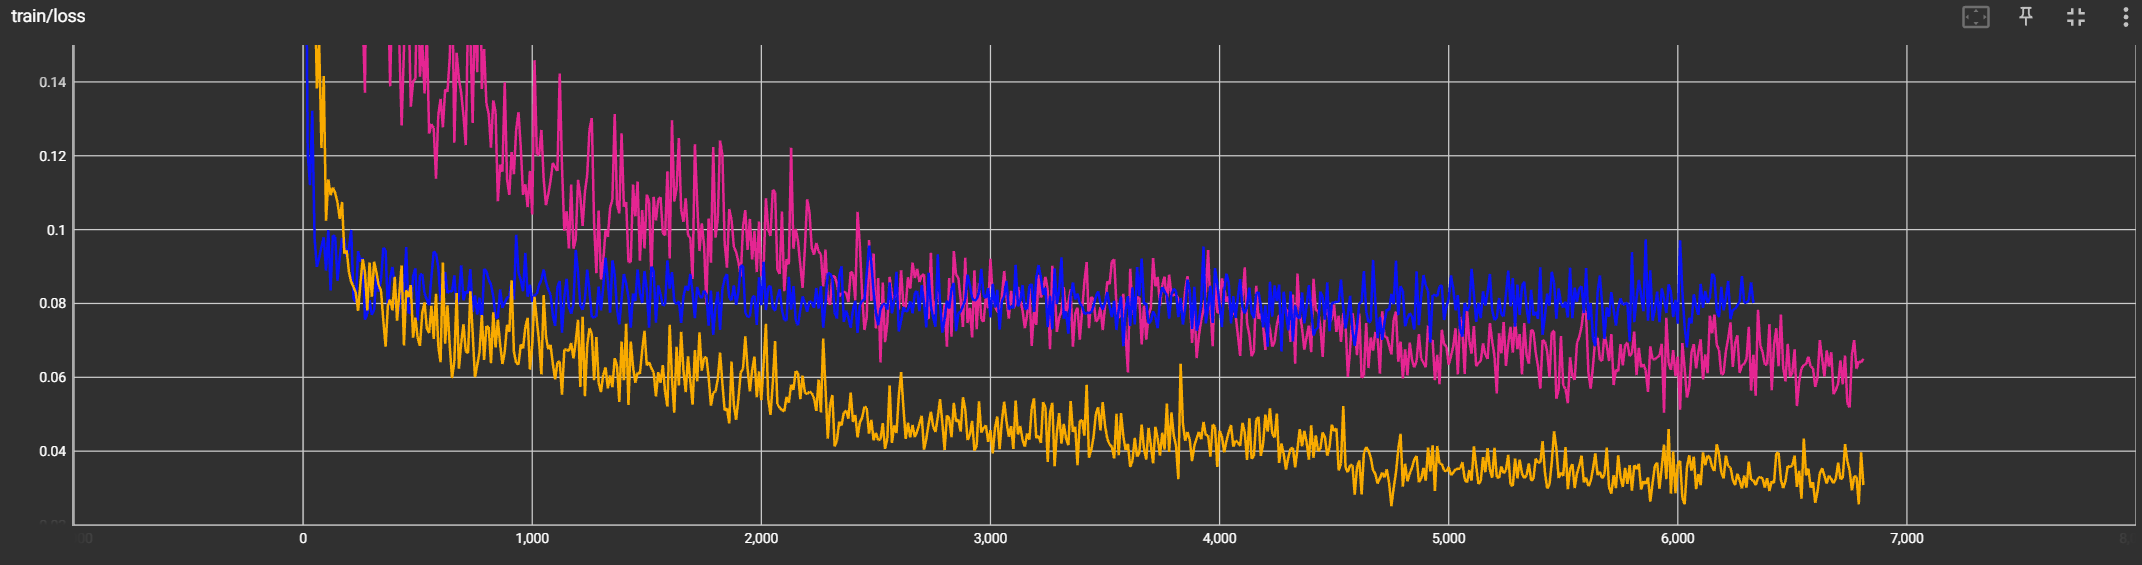

In [49]:
# Display the loss during finetuning (screenshot from Tensorboard)
display(Image(filename='./media/finetuning_loss.png'))

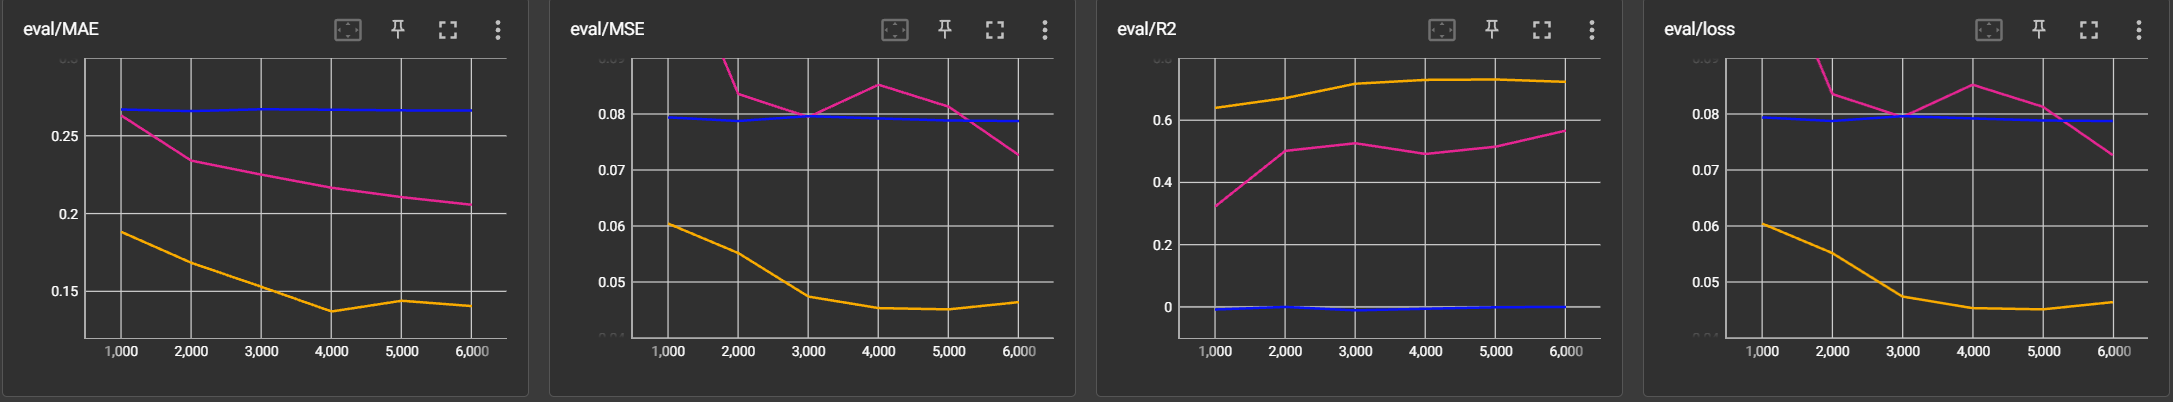

In [50]:
# Display MAE, MSE and R2 during finetuning (screenshot from Tensorboard)
display(Image(filename='./media/finetuning_metrics.png'))

After the finetuning with 3 epochs / 6000 steps on 96'450 single sentences, the following metrics can be observed:
- distilbert MAE: 0.2056, MSE: 0.07265, R2: 0.5666
- roberta MAE: 0.1405, MSE: 0.04641, R2: 0.7233
- xlnet MAE: 0.2662, MSE: 0.07874, R2: -8.03e-5

XLnet performed the worst, according to MSE, MAE and R2. All metrics are quite flat and not increasing (R2)/decreasing (MSE, MAE) as expected.Maybe there are issues with the data (too less training data, wrong preparation/tokenization etc.).  
RoBERTa outperforms distilbert (lower MAE, MSE and higher R2) as expected, since it is a further evolution of BERT and distilbert a lightweight version of BERT.

### 3.2 Inference/Test Metrics

As a second evaluation steps the generated metrics from the inference on the test datasets are inspected (*Tensorboard records can be found in "./inference/{model name}"*).

In [59]:
%tensorboard --logdir ./inference/ --port 6011

The following inference runs on the test dataset are considered:
- distilbert_sentences/runs/May29_10-32-11_Blackstar *(pink line)*
- roberta_sentences/runs/May27_19-25-30_Blackstar *(orange line)*
- xlnet_sentences/runs/May28_16-21-02_Blackstar *(blue line)*

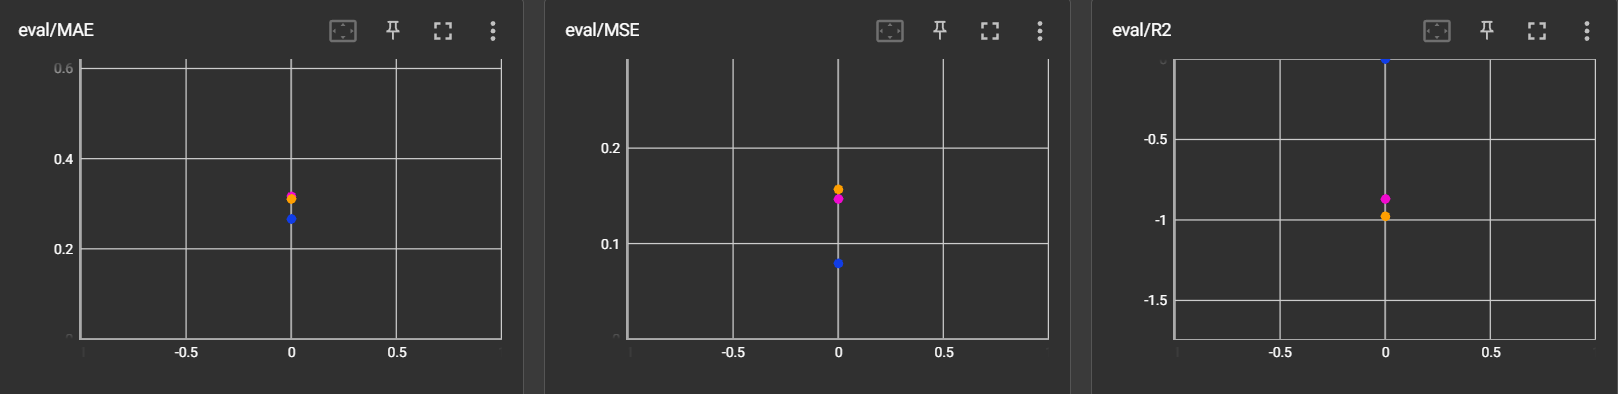

In [64]:
# Display evaluation metrics on test dataset (screenshot from Tensorboard)
display(Image(filename='./media/inference_metrics.png'))

The following metrics from the inference on the test dataset can be observed:

Distilbert: 
- loss: 0.1466914564371109
- MSE: 0.1466914564371109
- MAE: 0.31621062755584717
- R2: -0.8697550970092274

RoBERTa: 
- loss: 0.1567980796098709
- MSE: 0.1567980796098709
- MAE: 0.31052500009536743
- R2: -0.9772264512819131

XLNet:
- loss: 0.07921154797077179
- MSE: 0.07921154797077179
- MAE: 0.26618921756744385
- R2: 0.0002648013954396067

In general all models demonstrate bad performance according to the MSE, MAE and R2 on completely unseen, new data.  
Surprisingly, XLNet performs the best out of the 3 models on completely new data.


According to the metrics from the finetuning, we expect the best results from a RoBERTa model even if the model did not show a good inference performance.  
Therefore RoBERTa will be finetuned on the complete sentence dataset.

## 4. Full Training of selected Model

To speed up the full training, Parameter-Efficient Fine-Tuning (PEFT) (https://github.com/huggingface/peft) is considered.  
RoBERTa supports LoRa, Prefix Tuning, P-Tuning and Prompt Tuning: https://github.com/huggingface/peft#sequence-classification  

In [18]:
# Load the PEFT config with sequence classification task
peft_config = LoraConfig(task_type=TaskType.SEQ_CLS, inference_mode=True, r=8, lora_alpha=32, lora_dropout=0.1)

In [19]:
# Load the base RoBERTa model and the PEFT config
model_name = 'roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=1)  
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

trainable params: 1182722 || all params: 125532674 || trainable%: 0.942162675511875


In [20]:
def tokenize_and_format_sentence(examples):

    # Tokenize the text and map sentiment to label
    tokenized_inputs = roberta_tokenizer(examples['sentence'], truncation=True, padding='max_length')
    labels = examples['sentiment']
    
    # Return both the tokenized inputs and labels
    return {**tokenized_inputs, 'labels': labels}

# Load the tokenizer for RoBERTa
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

In [21]:
# Ensure correct dataset class is loaded
from datasets import Dataset

# Train, validation and test split (70%, 15% and 15%) on the full dataset
train_dataset, temp_df = train_test_split(sentence_df, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert pandas DataFrame to Huggingface Dataset
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)
test_dataset = Dataset.from_pandas(test_dataset)

# Tokenizing the datasets
train_dataset_roberta_sent = train_dataset.map(tokenize_and_format_sentence, batched=True)
val_dataset_roberta_sent = val_dataset.map(tokenize_and_format_sentence, batched=True)
test_dataset_roberta_sent = test_dataset.map(tokenize_and_format_sentence, batched=True)

# Set the correct data format for PyTorch
train_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset_roberta_sent.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/474970 [00:00<?, ? examples/s]

Map:   0%|          | 0/101779 [00:00<?, ? examples/s]

Map:   0%|          | 0/101780 [00:00<?, ? examples/s]

In [24]:
# Prepare to train the model
args = TrainingArguments(
    output_dir="./full/roberta_sentences_v3_old_st2_annots",
    evaluation_strategy="steps",
    eval_steps=5000,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_total_limit=1,
    gradient_accumulation_steps=4,
    seed=0,
    optim="adamw_torch", # Use newer PyTorch optimizer
    learning_rate=2e-5,
    logging_steps=10,
    fp16=True,
    report_to='tensorboard')

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_roberta_sent,
    eval_dataset=val_dataset_roberta_sent
)

In [25]:
%load_ext tensorboard

In [27]:
%tensorboard --logdir ./full/ --port 6012

In [28]:
# Delete GPU cache
torch.cuda.empty_cache()

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./models/roberta_full_sentences_v3_old_st2_annots")

Step,Training Loss,Validation Loss


## 5. Evaluation of fully trained Model & Sentiment Prediction

We ran 3 full training runs with PEFT. These are the results of the evaluation metrics during training:
- Full training run 1 with new stage2 sentiment predictions *(red line, mostly overplotted by run 2)*
- Full training run 2 with new stage2 sentiment predictions to validate results of run 1 *(orange line)*
- Full training run 3 with older stage2 sentiment predictions with more equally distributed sentiment classes *(green line)*

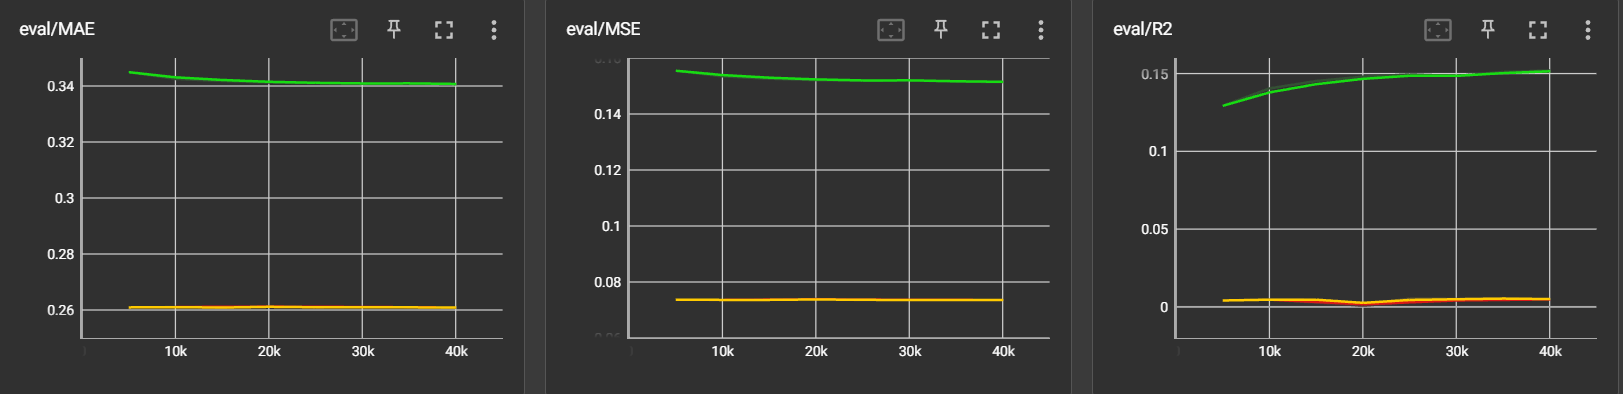

In [53]:
# Display evaluation metrics of full training runs (screenshot from Tensorboard)
display(Image(filename='./media/full_training_metrics.png'))

The older sentiment predictions from stage2 (which are the labels for the training) provide a better class (0.0, 0.5 and 1.0) distribution (*see also boxplots in chapter 1*).  
Within the training/evaluation a higher R2, MSE and MAE is resulting.

In [32]:
# Load full finetuned RoBERTa model
peft_model = './models/roberta_full_sentences_v3_old_st2_annots'
config = PeftConfig.from_pretrained(peft_model)
model = RobertaForSequenceClassification.from_pretrained(config.base_model_name_or_path, num_labels=1)
model = PeftModel.from_pretrained(model, peft_model)
model = model.to("cuda")

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [33]:
# Inpspect the model
model.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      

In [34]:
trainer_args_roberta = TrainingArguments(
    output_dir="./inference/roberta_full_v3",
    do_train = False,
    do_predict = True,
    fp16=True,
    report_to='tensorboard')

# Define RoBERTa test trainer
trainer_full_roberta = Trainer(
    model=model,
    compute_metrics=compute_metrics,
    args=trainer_args_roberta)

In [35]:
# Make predictions on the test dataset
pred_roberta_full = trainer_full_roberta.predict(test_dataset_roberta_sent)

In [36]:
trainer_full_roberta.evaluate(eval_dataset=test_dataset_roberta_sent)

{'eval_loss': 0.15218329429626465,
 'eval_MSE': 0.15218329429626465,
 'eval_MAE': 0.34134960174560547,
 'eval_R2': 0.15028100642197972,
 'eval_runtime': 539.6984,
 'eval_samples_per_second': 188.587,
 'eval_steps_per_second': 23.574}

In [45]:
%tensorboard --logdir ./inference/ --port 6013

As a next step, also hyperparameter tuning could be considered (e.g. https://medium.com/distributed-computing-with-ray/hyperparameter-optimization-for-transformers-a-guide-c4e32c6c989b).  
Due to time constraints, these approaches cannot be included.

## 8. Compare internal vs. external

The finetuned model is no used to predict the sentiment of all sentences in the documents.

### 8.1 Inference with the finetuned model

In [46]:
# Load full finetuned RoBERTa model
peft_model = './models/roberta_full_sentences_v3_old_st2_annots'
config = PeftConfig.from_pretrained(peft_model)
model = RobertaForSequenceClassification.from_pretrained(config.base_model_name_or_path, num_labels=1)
model = PeftModel.from_pretrained(model, peft_model)
model = model.to("cuda")

args_inference_roberta = TrainingArguments(
    output_dir="./inference/roberta_full_v3_old_st2_annots",
    do_train = False,
    do_predict = True,
    fp16=True,
    report_to='tensorboard')

# Define RoBERTa trainer
inference_roberta = Trainer(
    model=model,
    args=args_inference_roberta)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

In [54]:
df = load_old_sentiments()
exploded_df = df[['title', 'sentence_tokens']].explode('sentence_tokens').reset_index()
exploded_df.head()

,index,title,sentence_tokens
0,0,BeiersdorfAG Sustainability Report 2021,brands strategy sustainability agenda care bey...
1,0,BeiersdorfAG Sustainability Report 2021,successfully reduced carbon footprint absolute...
2,0,BeiersdorfAG Sustainability Report 2021,end consumer business returned levels reduced ...
3,0,BeiersdorfAG Sustainability Report 2021,decoupling human economic activity natural res...
4,0,BeiersdorfAG Sustainability Report 2021,inspired beiersdorf ambitious sustainability a...


In [55]:
# Ensure correct dataset class is loaded
from datasets import Dataset

# Convert pandas DataFrame to Huggingface Dataset
sentence_dataset = Dataset.from_pandas(exploded_df)

# Load the tokenizer for RoBERTa
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(model_name)

# Define the modified function to tokenize sentences
def tokenize_and_format_sentence(examples):
    tokenized_inputs = roberta_tokenizer(examples['sentence_tokens'], truncation=True, padding='max_length')
    return tokenized_inputs

# Tokenizing the datasets and set the correct data format for PyTorch
sentence_dataset = sentence_dataset.map(tokenize_and_format_sentence, batched=True)
sentence_dataset.set_format('torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/678529 [00:00<?, ? examples/s]

In [56]:
# Conduct sentiment prediction with the model
sentiment_predictions = inference_roberta.predict(sentence_dataset)

In [57]:
# Extract scores and add them to original dataframe
sentiment_scores = sentiment_predictions.predictions[:, 0]
# Add the sentiment scores to the sentences
exploded_df['sentiment_score'] = sentiment_scores
# Aggregate the sentiment scores back to the original 'index' or 'title'
aggregated_df = exploded_df.groupby('index')['sentiment_score'].apply(list).reset_index()

In [58]:
# Join the predicted sentiments to the data
final_df = df.merge(aggregated_df, left_index=True, right_on='index')
# Rename the column
final_df.rename(columns={'sentiment_score': 'st3_sentiment_llm_continuous'}, inplace=True)
# Create a new column that contains the mean of sentiment scores
final_df['st3_sentiment_llm_continuous_mean'] = final_df['st3_sentiment_llm_continuous'].apply(lambda x: sum(x)/len(x))
final_df.head()

,company,datatype,title,date,domain,esg_topics,internal,symbol,sentence_tokens,market_cap_in_usd_b,...,year_month,year,month,sentiment_llm_continuous,sentiment_llm_categorial,st2_sentiment_llm_continuous,st2_sentiment_llm_categorical,index,st3_sentiment_llm_continuous,st3_sentiment_llm_continuous_mean
0,Beiersdorf,sustainability_report,BeiersdorfAG Sustainability Report 2021,2021-03-31,NaN,"[CleanWater, GHGEmission, ProductLiability, Va...",1,BEI,[brands strategy sustainability agenda care be...,25.99,...,2021-03,2021,3,"[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...","[0.4510161280632019, 0.6138720512390137, 0.226...","[0.5, 0.5, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...",0,"[0.61181640625, 0.6142578125, 0.73291015625, 0...",0.594843
1,Deutsche Telekom,sustainability_report,DeutscheTelekomAG Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, Iso50001, GlobalWarming, Produc...",1,DTE,"[management facts, deutsche telekom cr report,...",101.78,...,2021-03,2021,3,"[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ...","[0.35756340622901917, 0.29088783264160156, 0.3...","[0.5, 0.0, 0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.5, ...",1,"[0.40380859375, 0.40283203125, 0.412109375, 0....",0.500225
2,Vonovia,sustainability_report,VonoviaSE Sustainability Report 2021,2021-03-31,NaN,"[Whistleblowing, DataSecurity, Vaccine, GHGEmi...",1,VNA,"[sustainable future, sustainability report dea...",20.35,...,2021-03,2021,3,"[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ...","[0.4570336639881134, 0.45287153124809265, 0.26...","[0.5, 0.5, 0.0, 0.5, 0.5, 0.5, 0.0, 0.5, 0.0, ...",2,"[0.5537109375, 0.5966796875, 0.432861328125, 0...",0.504318
3,Merck,sustainability_report,MerckKGaA Sustainability Report 2021,2021-03-31,NaN,"[DataSecurity, DataMisuse, DrugResistance, Iso...",1,MRK,[management employees profile attractive emplo...,87.64,...,2021-03,2021,3,"[0.36378589272499084, 0.6118267178535461, 0.48...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0.36378589272499084, 0.6118267178535461, 0.48...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...",3,"[0.4462890625, 0.59912109375, 0.63525390625, 0...",0.522807
4,MTU,sustainability_report,MTUAeroEngines Sustainability Report 2020,2020-03-31,NaN,"[WorkLifeBalance, Corruption, AirQuality, Data...",1,MTX,[sustainability goes far beyond climate action...,12.24,...,2020-03,2020,3,"[0.46082836389541626, 0.46208637952804565, 0.4...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ...","[0.46082836389541626, 0.46208637952804565, 0.4...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.5, 0.5, ...",4,"[0.62060546875, 0.73486328125, 0.65283203125, ...",0.545825


In [59]:
# Save the predicted sentiments as an output
if not os.path.exists('./output/'):  # Check if the directory exists and create it if it doesn't
    os.makedirs('./output/')
final_df.to_csv(f'./output/stage3_output_roberta_v3.csv', index=False, sep='|')

All stage outputs are stored on Google Drive:  
https://drive.google.com/drive/folders/1ATtCPPll6n_qvfMBu4ka84E3DZDS7d11

### 8.2 Comparison of internal/external Sentiments

We have trained the full RoBERTa training with 2 different stage2 outputs e.g., different class/sentiment distributions.  
- The initial full training with a quite imbalanced training dataset
- A second full training with a more balanced training dataset  

Both finetuned RoBERTA models were used to perform a sentiment analysis on all sentences.

#### First finetuning with imbalanced class distribution in training data & sentiment predictions on sentences

In [30]:
# Load training dataset with imbalanced class distribution
training_data_imb = pd.read_csv('../stage2/output/stage2_output.csv', delimiter = '|')
training_data_imb['st2_sentiment_llm_continuous'] = training_data_imb['st2_sentiment_llm_continuous'].apply(eval)
training_data_imb['st2_sentiment_llm_categorical'] = training_data_imb['st2_sentiment_llm_categorical'].apply(eval)
flat_training_data_imb_sentiment_cont = np.hstack(training_data_imb['st2_sentiment_llm_continuous'])
flat_training_data_imb_sentiment_cat= np.hstack(training_data_imb['st2_sentiment_llm_categorical'])

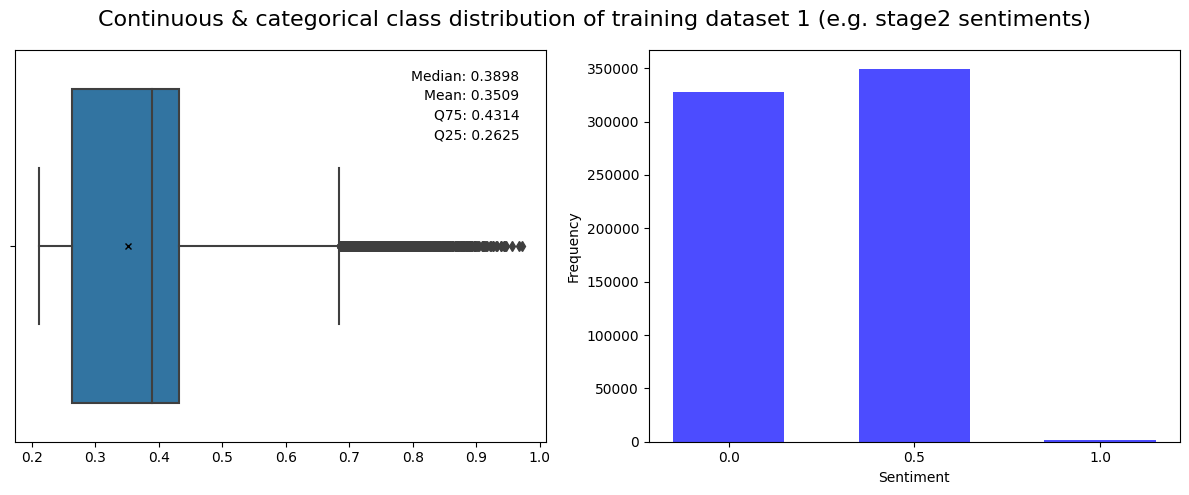

In [31]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Continuous & categorical class distribution of training dataset 1 (e.g. stage2 sentiments)', fontsize=16)

# Create boxplot
sns.boxplot(x=flat_training_data_imb_sentiment_cont, showmeans=True, meanprops={"marker":"x","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}, ax=axes[0])

# Calculate statistics
median = np.median(flat_training_data_imb_sentiment_cont)
mean = np.mean(flat_training_data_imb_sentiment_cont)
q75, q25 = np.percentile(flat_training_data_imb_sentiment_cont, [75 ,25])
iqr = q75 - q25
axes[0].text(0.95, 0.95, f"Median: {median:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.90, f"Mean: {mean:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.85, f"Q75: {q75:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.80, f"Q25: {q25:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)

# Count the occurrences of each value
value_counts = pd.Series(flat_training_data_imb_sentiment_cat).value_counts()
axes[1].bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0.0, 0.5, 1.0])
plt.tight_layout()
plt.show()

In [32]:
# Load the predicted sentiments, trained on more +imbalanced dataset
predictions_imb = pd.read_csv('../stage3/output/stage3_output.csv', delimiter = '|')

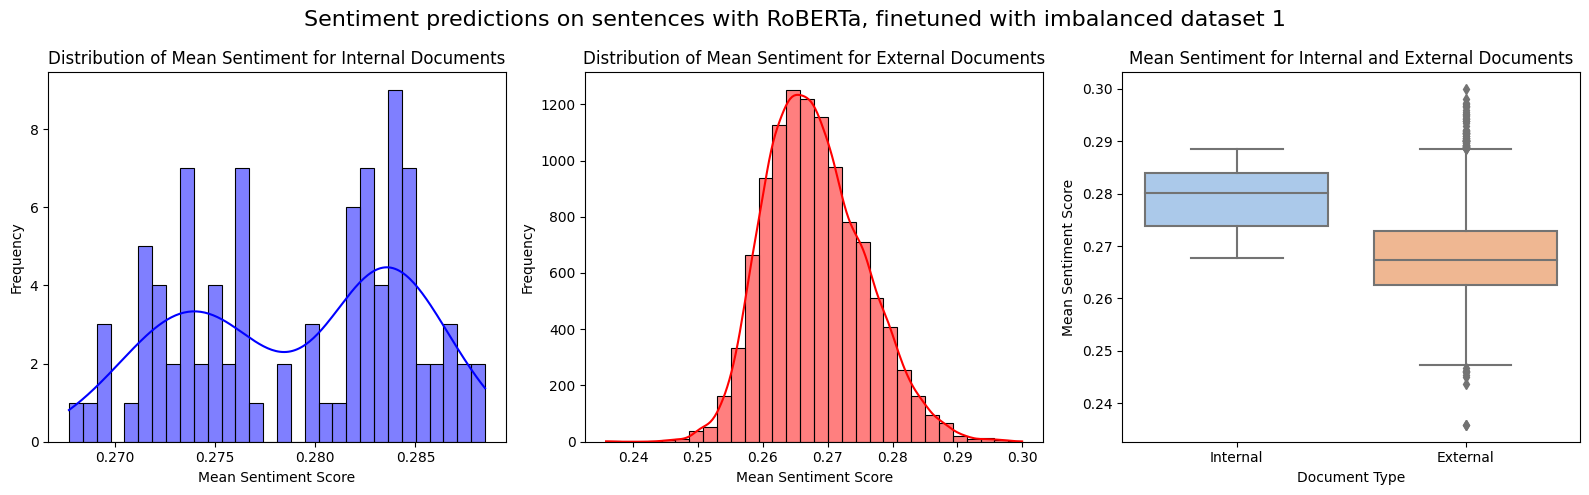

In [45]:
# Filter the data for internal/external documents
internal_df = predictions_imb[predictions_imb['internal'] == 1]
external_df = predictions_imb[predictions_imb['internal'] == 0]
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Sentiment predictions on sentences with RoBERTa, finetuned with imbalanced dataset 1', fontsize=16)

# Create the plot for internal documents
sns.histplot(internal_df['st3_sentiment_llm_continuous_mean'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title('Distribution of Mean Sentiment for Internal Documents')
axes[0].set_xlabel('Mean Sentiment Score')
axes[0].set_ylabel('Frequency')

# Create the plot for external documents
sns.histplot(external_df['st3_sentiment_llm_continuous_mean'], kde=True, color='red', bins=30, ax=axes[1])
axes[1].set_title('Distribution of Mean Sentiment for External Documents')
axes[1].set_xlabel('Mean Sentiment Score')
axes[1].set_ylabel('Frequency')

# Create a new DataFrame for boxplot
boxplot_df = predictions_imb.copy()
boxplot_df['Document Type'] = boxplot_df['internal'].map({0: 'External', 1: 'Internal'})

# Create the boxplot for internal and external documents
sns.boxplot(x='Document Type', y='st3_sentiment_llm_continuous_mean', data=boxplot_df, palette='pastel', ax=axes[2])
axes[2].set_title('Mean Sentiment for Internal and External Documents')
axes[2].set_xlabel('Document Type')
axes[2].set_ylabel('Mean Sentiment Score')

plt.tight_layout()
plt.show()

#### Second finetuning with less imbalanced class distribution in training data & sentiment predictions on sentences

In [34]:
# Load training dataset with less imbalanced class distribution
training_data_bal = pd.read_csv('../stage2/annotated/full_llm_annotated.csv', delimiter = '|')
training_data_bal['st2_sentiment_llm_continuous'] = training_data_bal['sentiment_llm_continuous'].apply(eval)
training_data_bal['st2_sentiment_llm_categorical'] = training_data_bal['sentiment_llm_categorial'].apply(eval)
flat_training_data_bal_sentiment_cont = np.hstack(training_data_bal['st2_sentiment_llm_continuous'].values)
flat_training_data_bal_sentiment_cat= np.hstack(training_data_bal['st2_sentiment_llm_categorical'].values)

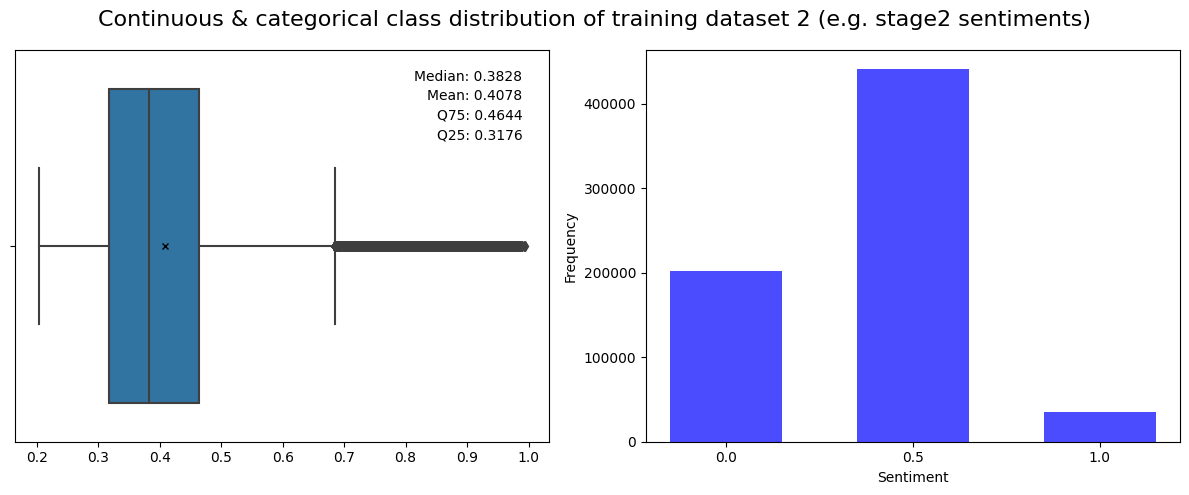

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Continuous & categorical class distribution of training dataset 2 (e.g. stage2 sentiments)', fontsize=16)

# Create boxplot
sns.boxplot(x=flat_training_data_bal_sentiment_cont, showmeans=True, meanprops={"marker":"x","markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}, ax=axes[0])

# Calculate statistics
median = np.median(flat_training_data_bal_sentiment_cont)
mean = np.mean(flat_training_data_bal_sentiment_cont)
q75, q25 = np.percentile(flat_training_data_bal_sentiment_cont, [75 ,25])
iqr = q75 - q25
axes[0].text(0.95, 0.95, f"Median: {median:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.90, f"Mean: {mean:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.85, f"Q75: {q75:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)
axes[0].text(0.95, 0.80, f"Q25: {q25:.4f}", horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes)

# Count the occurrences of each value
value_counts = pd.Series(flat_training_data_bal_sentiment_cat).value_counts()
axes[1].bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, width=0.3)
axes[1].set_xlabel('Sentiment')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0.0, 0.5, 1.0])
plt.tight_layout()
plt.show()

In [36]:
# Load the predicted sentiments, trained on imbalanced dataset
predictions_bal = pd.read_csv('./output/stage3_output_roberta_v3.csv', delimiter = '|')

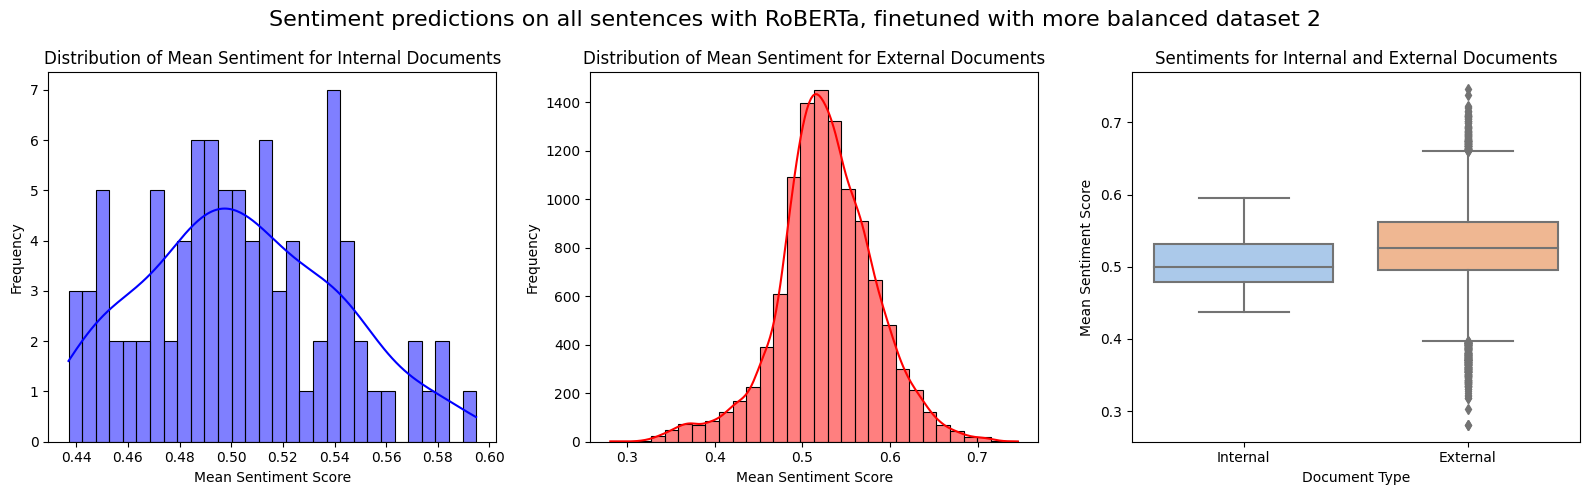

In [44]:
# Filter the data for internal/external documents
internal_df = predictions_bal[predictions_bal['internal'] == 1]
external_df = predictions_bal[predictions_bal['internal'] == 0]
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Sentiment predictions on all sentences with RoBERTa, finetuned with more balanced dataset 2', fontsize=16)

# Create the plot for internal documents
sns.histplot(internal_df['st3_sentiment_llm_continuous_mean'], kde=True, color='blue', bins=30, ax=axes[0])
axes[0].set_title('Distribution of Mean Sentiment for Internal Documents')
axes[0].set_xlabel('Mean Sentiment Score')
axes[0].set_ylabel('Frequency')

# Create the plot for external documents
sns.histplot(external_df['st3_sentiment_llm_continuous_mean'], kde=True, color='red', bins=30, ax=axes[1])
axes[1].set_title('Distribution of Mean Sentiment for External Documents')
axes[1].set_xlabel('Mean Sentiment Score')
axes[1].set_ylabel('Frequency')

# Create a new DataFrame for boxplot
boxplot_df = predictions_bal.copy()
boxplot_df['Document Type'] = boxplot_df['internal'].map({0: 'External', 1: 'Internal'})

# Create the boxplot for internal and external documents
sns.boxplot(x='Document Type', y='st3_sentiment_llm_continuous_mean', data=boxplot_df, palette='pastel', ax=axes[2])
axes[2].set_title('Sentiments for Internal and External Documents')
axes[2].set_xlabel('Document Type')
axes[2].set_ylabel('Mean Sentiment Score')
plt.tight_layout()
plt.show()

It can be observed, the imbalance in the training dataset directly affects the sentiment predictions with the finetuned RoBERTa model.  

